# 在二维平面上渲染三维对象

- 计算三维向量在二维平面的投影
- 计算三维图形在二维平面的投影
- 计算 3 个三维向量组成的平面的法线向量
- 利用点积计算三维面的朝向
- 为图形着色

**目标:** 渲染一个简单的三维形状，称为八面体. 立方体有 `6` 个面, 所有面都是正方形; 而八面体有 `8` 个面, 所有面都是三角形. 可以把八面体看成两个互相叠加的四边金字塔

![X](../assets/octahedron.png)

如果它是一个实体, 我们就看不到对面的边了, 只能看到 `8` 个三角形面中的 `4` 个

![X](../assets/octahedron-front.png)

渲染八面体归根结底就是确定我们需要显示的 `4` 个三角形, 并进行适当的着色

## 1. 使用向量定义三维对象


八面体是一个简单的例子, 因为它只有 `6` 个角 (顶点). 我们可以为其设置简单的坐标: `(1, 0, 0)`, `(0, 1, 0)` 和 `(0, 0, 1)` 以及与它们相反的三个向量

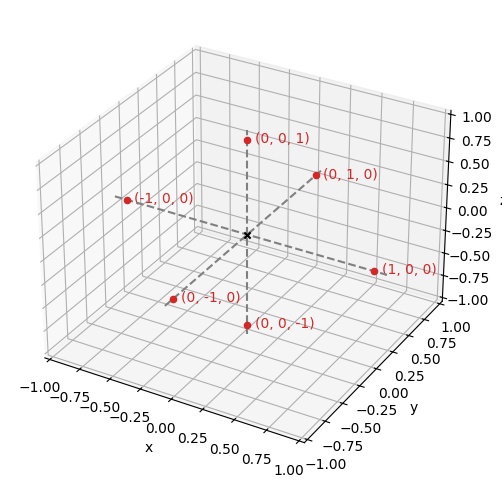

In [4]:
from draw.component import Color, Points3D, draw3d

# 定义 6 个顶点的坐标
coords = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (-1, 0, 0),
    (0, -1, 0),
    (0, 0, -1),
]

# 绘制 8 边形的 6 个顶点
draw3d(
    [Points3D(coords, color=Color.red())],
    xlim=(-1, 1),
    ylim=(-1, 1),
    zlim=(-1, 1),
)

将相关顶点连接后, 即可得到 `8` 面体的边

In [5]:
from typing import Iterable, List

from common.typedef import Vector3D


def vertices(faces: Iterable[Iterable[Vector3D]]) -> List[Vector3D]:
    """从定义的向量集合中获取不重复的向量点坐标

    Args:
        `faces` (`Polygons`): 向量集合

    Returns:
        `Vector`: 向量点坐标
    """
    return list({vertex for face in faces for vertex in face})

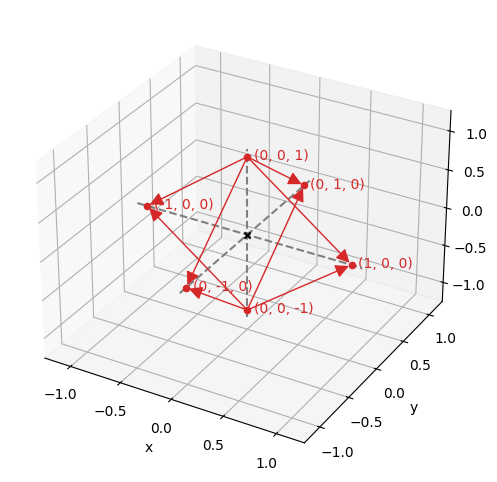

In [6]:
from common.typedef import Vector, Vector3D
from common.vector import vertices
from draw.component import Arrow3D, Color, Points3D, draw3d

# 定义 8 边形的 8 条边
sides = [
    [(0, 0, 1), (-1, 0, 0)],
    [(0, 0, 1), (0, 1, 0)],
    [(0, 0, 1), (1, 0, 0)],
    [(0, 0, 1), (0, -1, 0)],
    [(0, 0, -1), (-1, 0, 0)],
    [(0, 0, -1), (0, 1, 0)],
    [(0, 0, -1), (1, 0, 0)],
    [(0, 0, -1), (0, -1, 0)],
]

# 绘制图形
draw3d(
    [
        Points3D(vertices(sides), color=Color.red()),  # 绘制 8 条边对应的 6 个顶点
        *[Arrow3D(s[1], s[0], color=Color.red()) for s in sides],  # 绘制 8 条边
    ]
)

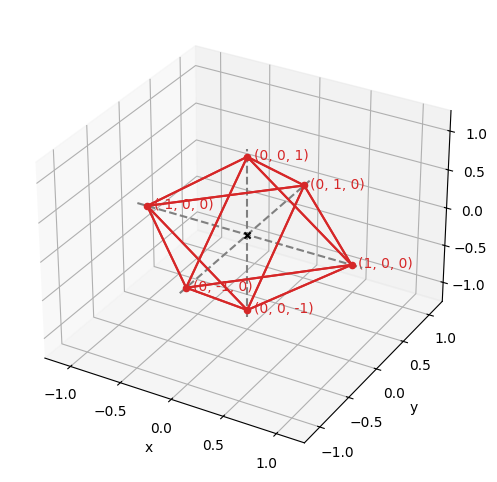

In [7]:
from common.typedef import Vector
from common.vector import vertices
from draw.component import Arrow3D, Color, Points3D, Polygon3D, draw3d

#  定义 8 边形对应的 8 个三角形面
octahedron = [
    ((1, 0, 0), (0, 1, 0), (0, 0, 1)),
    ((1, 0, 0), (0, 0, -1), (0, 1, 0)),
    ((1, 0, 0), (0, 0, 1), (0, -1, 0)),
    ((1, 0, 0), (0, -1, 0), (0, 0, -1)),
    ((-1, 0, 0), (0, 0, 1), (0, 1, 0)),
    ((-1, 0, 0), (0, 1, 0), (0, 0, -1)),
    ((-1, 0, 0), (0, -1, 0), (0, 0, 1)),
    ((-1, 0, 0), (0, 0, -1), (0, -1, 0)),
]

# 计算 6 个顶点
draw3d(
    [
        Points3D(vertices(octahedron), color=Color.red()),  # 绘制 8 条边对应的 6 个顶点
        *[Polygon3D(vs, color=Color.red()) for vs in octahedron],  # 绘制 8 个面
    ]
)

## 2. 二维投影

**知识:** 要把三维点变成二维点, 必须选择我们的三维观察方向

一旦从视角上确定了定义“上”和“右”的两个三维向量, 就可以将任意三维向量投射到它们上面, 得到两个分量而不是三个分量

In [8]:
from common.typedef import Vector3D
from common.vector import dot, length


def component(v: Vector3D, direction: Vector3D) -> float:
    """利用点积提取三维向量在给定方向上坐标轴的分量

    Args:
        `v` (`Vector3D`): 三维向量
        `direction` (`Vector3D`): 三维向量的方向, 为仅有一个维度为 `1` 的三维向量

    Returns:
        `float`: 三维向量在二维坐标指定方向的分量
    """
    # 方向点积是一个只有一个维度为 1
    # 向量和方向的点积除以方向向量的长度得到三维坐标在二维坐标轴的一个分量
    return dot(v, direction) / length(direction)

通过对两个方向硬编码 (在本例中是 $(1, 0, 0)$ 和 $(0, 1, 0)$), 可以建立一种从三个坐标向下投影到两个坐标的方法

类似于把三维向量“压平”到二维平面上. 删除 $z$ 分量会使向量的深度消失

![X](../assets/projection.png)

In [9]:
from common.typedef import Vector2D, Vector3D


def to_2d_projection(v: Vector3D) -> Vector2D:
    """接收一个三维向量或三个数组成的元组, 并返回一个二维向量或两个数组成的元组

    Args:
        `v` (`Vector3D`): 三维向量

    Returns:
        `Vector2D`: 三维向量在二维坐标的投影
    """
    # 将三维坐标转化为二维坐标 x 和 y 轴的分量, 即组成三维坐标在二维坐标的投影
    return (component(v, (1, 0, 0)), component(v, (0, 1, 0)))

 由此, 通过将三维顶点坐标转为二维坐标, 即可以将三维的一个平面转换成二维的投影

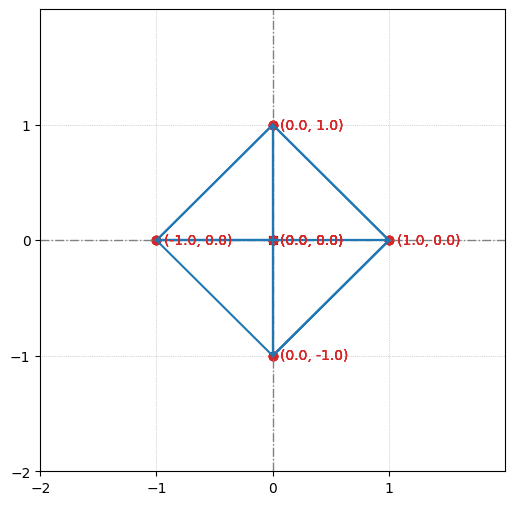

In [10]:
from common.vector import to_2d_projection
from draw.component import Color, Points2D, Polygon2D, draw2d

#  定义 8 边形对应的 8 个三角形面
octahedron = [
    ((1, 0, 0), (0, 1, 0), (0, 0, 1)),
    ((1, 0, 0), (0, 0, -1), (0, 1, 0)),
    ((1, 0, 0), (0, 0, 1), (0, -1, 0)),
    ((1, 0, 0), (0, -1, 0), (0, 0, -1)),
    ((-1, 0, 0), (0, 0, 1), (0, 1, 0)),
    ((-1, 0, 0), (0, 1, 0), (0, 0, -1)),
    ((-1, 0, 0), (0, -1, 0), (0, 0, 1)),
    ((-1, 0, 0), (0, 0, -1), (0, -1, 0)),
]

# 将一组三维顶点坐标转为二维投影
faces_2d = [to_2d_projection(v) for face in octahedron for v in face]

# 绘制三维坐标顶点组成的面在二维坐标的投影
draw2d(
    [
        Points2D(faces_2d, color=Color.red()),
        Polygon2D(faces_2d, color=Color.blue()),
    ]
)

## 3. 确定面的朝向和阴影

**知识:** 给定法线向量 (垂直于每个面的向量) 和一个指向光源的向量, 它们的点积就说明了其对齐程度

由于只考虑方向, 光源向量可以选择长度为 `1` 的向量, 则:
- 如果该面完全朝向光源, 则点积介于 `0` 和 `1` 之间;
- 如果该面与光源的角度超过 `90°`, 则将完全不能被照亮;

In [11]:
from common.typedef import Triangle
from common.vector import scale, subtract, length, Vector3D, cross


def unit(v: Vector3D) -> Vector3D:
    """返回和输入向量方向相同, 但长度为 `1` 的向量

    Args:
        `v` (`Vector`): 输入向量

    Returns:
        `Vector`: 和输入向量方向一致, 但长度为 `1` 的向量
    """
    return scale(1.0 / length(v), v)


def normal(face: Triangle) -> Vector3D:
    """计算一个三维面的法线 (垂直面的向量)

    Args:
        `face` (`Triangle`): 一个表示面的三角形

    Returns:
        `Vector3D`: 垂直三维平面的法向量
    """
    return cross(subtract(face[1], face[0]), subtract(face[2], face[0]))

**练习:** 绘制三维平面的法线

法线可以用于计算三维图形的光线射入角度

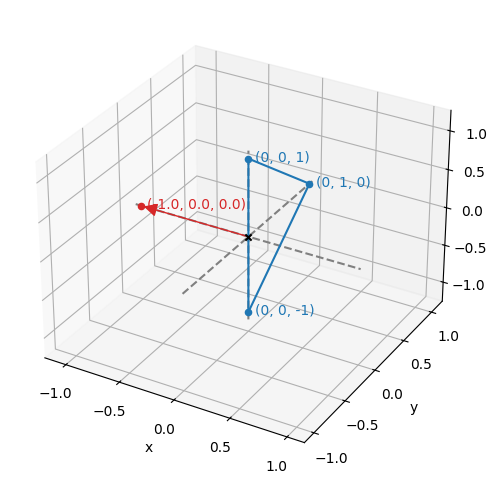

In [12]:
from common.vector import normal, unit
from draw.component import Arrow3D, Color, Points3D, Polygon3D, draw3d

# 通过三个向量定义一个面
face = ((0, 0, 1), (0, 1, 0), (0, 0, -1))

# 计算平面的法线
n = unit(normal(face))

# 绘制面和法线
draw3d(
    [
        Points3D(face, color=Color.blue()),
        Polygon3D(face, color=Color.blue()),
        Points3D([n], color=Color.red()),
        Arrow3D(n, color=Color.red()),
    ]
)

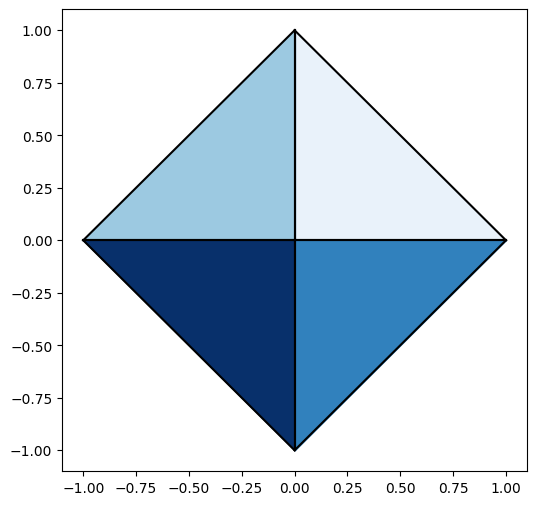

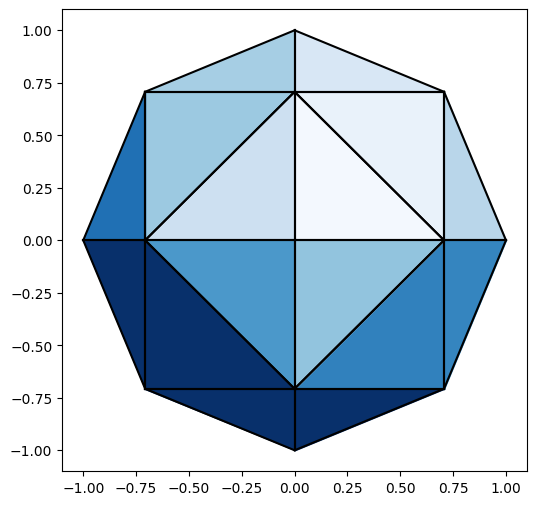

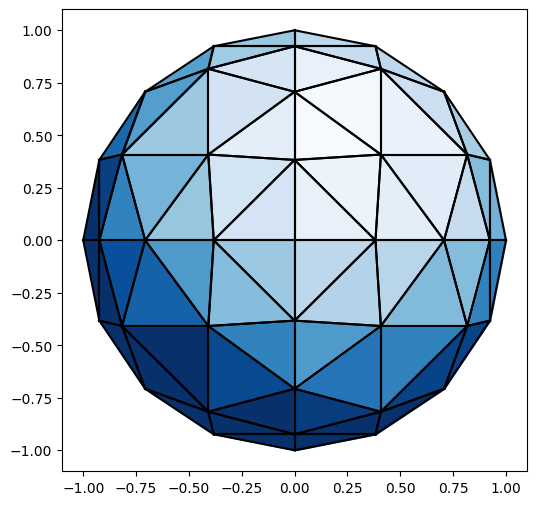

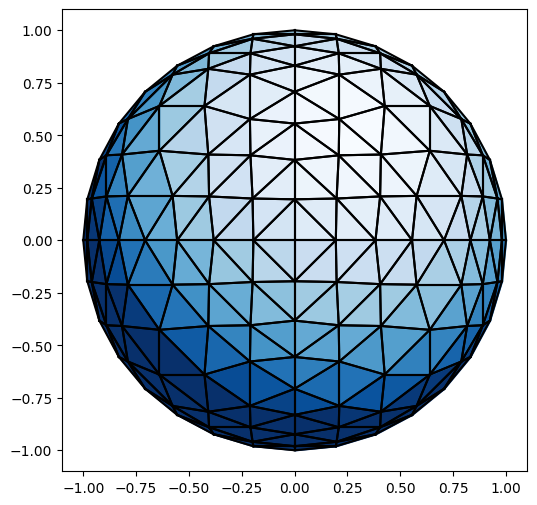

In [18]:
from typing import Iterable, List, Optional, Sequence

import matplotlib as mpl
import matplotlib.pyplot as plt
from common.typedef import Triangle
from common.vector import (
    Vector3D,
    add,
    as_triangle,
    dot,
    normal,
    to_2d_projection,
    unit,
)
from draw.component import Color, Polygon2D
from matplotlib.collections import PatchCollection
from matplotlib.colors import Colormap
from matplotlib.patches import Polygon


def draw_polygons(polygons: Iterable[Polygon2D]) -> None:
    """绘制多边形和填充色"""
    # 获取坐标系对象
    _, ax = plt.subplots()

    # 遍历所有的多边形对象
    for polygon in polygons:
        if polygon.color:
            # 遍历多边形的顶点向量
            for i in range(0, len(polygon.vertices)):
                # 获取相邻顶点向量的坐标
                x1, y1 = polygon.vertices[i]
                x2, y2 = polygon.vertices[(i + 1) % len(polygon.vertices)]

                # 用线段连接两个相邻顶点向量坐标
                plt.plot([x1, x2], [y1, y2], color=polygon.color.value())

        if polygon.fill:
            # 设置多边形顶点和填充色
            p = PatchCollection(
                [Polygon(polygon.vertices, closed=True)],  # type: ignore
                color=polygon.fill.value(),
            )
            ax.add_collection(p)  # type: ignore

    # 设置坐标轴尺寸
    plt.gcf().set_size_inches(6, 6)
    # 显示结果
    plt.show()


_color_blue = mpl.colormaps.get_cmap("Blues")  # type: ignore


def render(
    faces: Iterable[Triangle],
    light=(1, 2, 3),
    color_map: Colormap = _color_blue,
    lines_color: Optional[Color] = None,
) -> None:
    """绘制三维图形 (在二维坐标系)

    Args:
        `faces` (`Iterable[Polygon2D]`): 由多个三角形面组成的多面体向量集合
        `light` (tuple, optional): 光线的入射向量. Defaults to `(1, 2, 3)`.
        `color_map` (`Optional[Colormap]`, optional): 调色板, 用于绘制光线照射的颜色. Defaults to `None`.
        `lines_color` (`Optional[Color]`, optional): 绘制多边形边线颜色. Defaults to `None`.
    """
    polygons = []

    # 遍历所有的三角形
    for face in faces:
        # 计算每个三角形平面的法线
        un = unit(normal(face))

        # 判断法线的 z 轴为正 (指向正面) 时, 绘制阴影
        if un[2] > 0:
            # 法线向量和光线向量的点积越大 (重合度越高), 则阴影越少 (亮度越高)
            c = Color(color_map(1 - dot(un, unit(light))))

            # 通过三角形向量产生一个多边形图形
            p = Polygon2D(
                [to_2d_projection(v) for v in face],  # 计算三维平面在二维坐标的投影
                color=lines_color or Color.black(),  # 设置三角形边线颜色
                fill=c,  # 设置阴影 (用于在二维坐标系体现三维视觉效果)
            )
            polygons.append(p)

    # 绘制所有的多边形对象
    draw_polygons(polygons)


#  定义 8 边形对应的 8 个三角形面
octahedron = [
    ((1, 0, 0), (0, 1, 0), (0, 0, 1)),
    ((1, 0, 0), (0, 0, -1), (0, 1, 0)),
    ((1, 0, 0), (0, 0, 1), (0, -1, 0)),
    ((1, 0, 0), (0, -1, 0), (0, 0, -1)),
    ((-1, 0, 0), (0, 0, 1), (0, 1, 0)),
    ((-1, 0, 0), (0, 1, 0), (0, 0, -1)),
    ((-1, 0, 0), (0, -1, 0), (0, 0, 1)),
    ((-1, 0, 0), (0, 0, -1), (0, -1, 0)),
]

# 在二维坐标绘制 8 面体
render(octahedron)


def split(face: Triangle) -> List[Triangle]:
    """将每个三角形面四等分

    Args:
        `face` (`Triangle`): 表示一个面的三角形

    Returns:
        `List[Triangle]`: 等分后的四个三角形
    """
    # 计算三角形每个向量的中点
    midpoints = as_triangle(
        unit(add(face[i], face[(i + 1) % len(face)])) for i in range(len(face))
    )

    # 将三角形的三个向量和三个中点向量重新组合成四个三角形向量
    triangles = [
        as_triangle([face[i], midpoints[i], midpoints[(i - 1) % len(face)]])
        for i in range(len(face))
    ]

    # 返回四个三角形向量集合
    return [midpoints] + triangles


def rec_split(faces: Sequence[Triangle], depth=0) -> List[Triangle]:
    """将一个多面体的每个面 (三角形) 分为四分, 得到 N * 4 面体

    Args:
        faces (Polygons): 组成多面体的三角形集合
        depth (int, optional): 分割的次数. Defaults to `0`.

    Returns:
        List[Face]: 分割后的 N * 4 面体
    """
    # 分割完毕, 返回结果
    if depth == 0:
        return list(faces)

    # 进行异常分割
    return rec_split(
        [new_face for face in faces for new_face in split(face)],
        depth - 1,
    )


def sphere_approx(n: int) -> List[Triangle]:
    """将 8 面体进行分割, 每个面平分为 4 个面

    Args:
        n (int): 分割的次数

    Returns:
        Polygons: 分割后的多面体
    """
    return rec_split(octahedron, n)


# 绘制 32 面体
render(sphere_approx(1))

# 绘制 128 面体
render(sphere_approx(2))

# 绘制 512 面体
render(sphere_approx(3))

**练习:** 上面的 8 面体还不能很明显的体现三维图形的感觉, 如果有更多的面这可以显示的的更为明显

下面的一系列函数可以将一个面 (三角形) 分隔为四个面 (三角形), 从而将 8 面体分割为 `32`, `128`, `512` 或更多的面体

**练习:** 找到定义八面体 12 条边的向量对, 并绘制出所有的边

八面体的顶部是 $(0, 0, 1)$. 它通过 `4` 条边与 $xy$ 平面上的全部 `4` 个点相连. 同样, 八面体的底部是 $(0, 0, -1)$, 它也连接到 $xy$ 平面上的全部 `4` 个点. 最后, $xy$ 平面上的 `4` 个点相互连接形成正方形

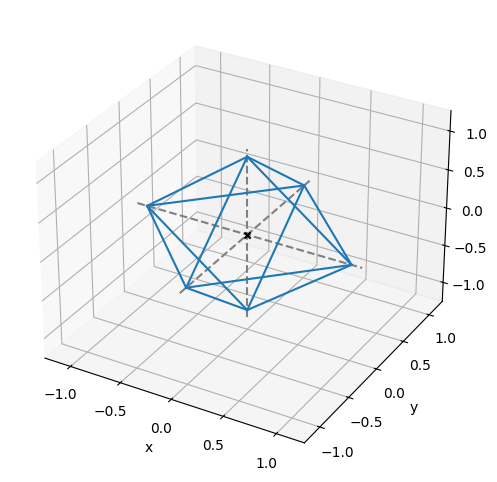

In [14]:
from draw.component import Segment3D, draw3d

# 定义 8 面体的顶坐标
top = (0, 0, 1)

# 定义 8 面体的底坐标
bottom = (0, 0, -1)

# 定义 8 面体在 xy 坐标轴定义平面的 4 个坐标
xy_plane = [
    (1, 0, 0),
    (0, 1, 0),
    (-1, 0, 0),
    (0, -1, 0),
]

# 计算所有的边
edges = (
    [Segment3D(top, p) for p in xy_plane]
    + [Segment3D(bottom, p) for p in xy_plane]  # 顶坐标和 xy 平面 4 个坐标连接
    + [  # 底坐标和 xy 平面 4 个坐标连接
        Segment3D(xy_plane[i], xy_plane[(i + 1) % 4]) for i in range(4)
    ]  # xy 平面的 4 个坐标相互连接
)

# 绘制所有的边
draw3d(edges)